In [2]:
import pandas as pd
import numpy as np

from common.serialization import pickle_save, pickle_load

from feature_pr import * #make_counters, make_counters_test, compress_vals, replace_val, make_pairs

In [1]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

In [5]:
data = pd.read_csv('data/credit_train.csv', sep=';', encoding='cp1251')
data_test = pd.read_csv('data/credit_test.csv', sep=';', encoding='cp1251')

In [6]:
a = ['РЕСП', 'ОБЛ', 'ОБЛАСТЬ', 'КРАЙ', 'ОБЛ.', 'РЕСП.', 'Р-Н', 'АО', 'КРАЙ.', '-', 'Г', 'Г.', 'АОБЛ', 'РЕСПУБЛИКА',
    'ОКРУГ', 'АВТОНОМНЫЙ']

data.monthly_income.fillna(-1, inplace=True)
data.living_region.fillna('N', inplace=True)
data.credit_count.fillna(5, inplace=True)
data.overdue_credit_count.fillna(2, inplace=True)
data['credit_sum'] = data.credit_sum.apply(lambda x: float(x.replace(',', '.')))
data['score_shk'] = data.score_shk.apply(lambda x: float(x.replace(',', '.')))
data['living_region'] = data.living_region.apply(lambda x: ''.join([y for y in x.upper().split() if y not in a]))
data['living_region'] = data.living_region.apply(lambda x: ''.join([y for y in x.split('.') if y not in a]))

data_test.monthly_income.fillna(-1, inplace=True)
data_test.living_region.fillna('N', inplace=True)
data_test.credit_count.fillna(5, inplace=True)
data_test.overdue_credit_count.fillna(2, inplace=True)
data_test['credit_sum'] = data_test.credit_sum.apply(lambda x: float(x.replace(',', '.')))
data_test['score_shk'] = data_test.score_shk.apply(lambda x: float(x.replace(',', '.')))
data_test['living_region'] = data_test.living_region.apply(lambda x: ''.join([y for y in x.upper().split() if y not in a]))
data_test['living_region'] = data_test.living_region.apply(lambda x: ''.join([y for y in x.split('.') if y not in a]))

data.loc[data.living_region == 'САХА/ЯКУТИЯ/', 'living_region'] = 'САХА'
data.loc[data.living_region == 'САХА(ЯКУТИЯ)', 'living_region'] = 'САХА'
data.loc[data.living_region == 'ХАНТЫ-МАНСИЙСКИЙЮГРА', 'living_region'] = 'ХАНТЫ-МАНСИЙСКИЙ'
data.loc[data.living_region == 'ХАНТЫ-МАНСИЙСКИЙЮ', 'living_region'] = 'ХАНТЫ-МАНСИЙСКИЙ'
data.loc[data.living_region == 'ЕВРЕЙСКАЯАВТОНОМНАЯ', 'living_region'] = 'ЕВРЕЙСКАЯ'
data.loc[data.living_region == 'ЧУВАШСКАЯЧУВАШИЯ', 'living_region'] = 'ЧУВАШСКАЯ'
data.loc[data.living_region == 'ЧУВАШИЯЧУВАШСКАЯ', 'living_region'] = 'ЧУВАШСКАЯ'
data.loc[data.living_region == 'СЕВЕРНАЯОСЕТИЯАЛАНИЯ', 'living_region'] = 'ОСЕТИЯ'
data.loc[data.living_region == 'СЕВОСЕТИЯАЛАНИЯ', 'living_region'] = 'ОСЕТИЯ'
data.loc[data.living_region == 'ГОРЬКОВСКАЯ', 'living_region'] = 'НИЖЕГОРОДСКАЯ'
data.loc[data.living_region == 'ПЕРМСКАЯ', 'living_region'] = 'ПЕРМСКИЙ'
data.loc[data.living_region == 'КАМЧАТСКАЯ', 'living_region'] = 'КАМЧАТСКИЙ'
data.loc[data.living_region == 'ЧУКОТСКИЙАO', 'living_region'] = 'ЧУКОТСКИЙ'
data.loc[data.living_region == 'АЛТАЙ', 'living_region'] = 'АЛТАЙСКИЙ'

data_test.loc[data_test.living_region == 'САХА/ЯКУТИЯ/', 'living_region'] = 'САХА'
data_test.loc[data_test.living_region == 'САХА(ЯКУТИЯ)', 'living_region'] = 'САХА'
data_test.loc[data_test.living_region == 'ХАНТЫ-МАНСИЙСКИЙЮГРА', 'living_region'] = 'ХАНТЫ-МАНСИЙСКИЙ'
data_test.loc[data_test.living_region == 'ХАНТЫ-МАНСИЙСКИЙЮ', 'living_region'] = 'ХАНТЫ-МАНСИЙСКИЙ'
data_test.loc[data_test.living_region == 'ЕВРЕЙСКАЯАВТОНОМНАЯ', 'living_region'] = 'ЕВРЕЙСКАЯ'
data_test.loc[data_test.living_region == 'ЧУВАШСКАЯЧУВАШИЯ', 'living_region'] = 'ЧУВАШСКАЯ'
data_test.loc[data_test.living_region == 'ЧУВАШИЯЧУВАШСКАЯ', 'living_region'] = 'ЧУВАШСКАЯ'
data_test.loc[data_test.living_region == 'СЕВЕРНАЯОСЕТИЯАЛАНИЯ', 'living_region'] = 'ОСЕТИЯ'
data_test.loc[data_test.living_region == 'СЕВОСЕТИЯАЛАНИЯ', 'living_region'] = 'ОСЕТИЯ'
data_test.loc[data_test.living_region == 'ГОРЬКОВСКАЯ', 'living_region'] = 'НИЖЕГОРОДСКАЯ'
data_test.loc[data_test.living_region == 'ПЕРМСКАЯ', 'living_region'] = 'ПЕРМСКИЙ'
data_test.loc[data_test.living_region == 'КАМЧАТСКАЯ', 'living_region'] = 'КАМЧАТСКИЙ'
data_test.loc[data_test.living_region == 'ЧУКОТСКИЙАO', 'living_region'] = 'ЧУКОТСКИЙ'
data_test.loc[data_test.living_region == 'АЛТАЙ', 'living_region'] = 'АЛТАЙСКИЙ'

In [7]:
counters_cols = ['gender', 'marital_status', 'job_position', 'credit_month', 'tariff_id', 
                'education', 'living_region', 'age', 'credit_count', 'overdue_credit_count']
one_hot_cols = ['gender', 'marital_status', 'job_position', 'credit_month', 'education', 'credit_count']
other_cols = ['credit_sum', 'score_shk', 'monthly_income', 'monthly_credit_sum']

data['monthly_credit_sum'] = data.credit_sum / data.credit_month
data_test['monthly_credit_sum'] = data_test.credit_sum / data_test.credit_month

# Объединим редко встречающиеся значения признаков
data.loc[data.credit_count > 5, 'credit_count'] = 5
data_test.loc[data_test.credit_count > 5, 'credit_count'] = 5
data.loc[data.overdue_credit_count > 2, 'overdue_credit_count'] = 2
data_test.loc[data_test.overdue_credit_count > 2, 'overdue_credit_count'] = 2

compress_vals(data, data_test, 'living_region', 30, 'N')
compress_vals(data, data_test, 'tariff_id', 30, 2.0)
compress_vals(data, data_test, 'job_position', 150, 'N')

data['age_group'] = 0
data_test['age_group'] = 0
a = [range(17, 22), range(22, 25), range(25, 38), range(38, 50), range(50, 58), range(58, 66), range(66, 100)]
for i in range(len(a)):
    for val in a[i]:
        data.loc[data.age == val, 'age_group'] = i
        data_test.loc[data_test.age == val, 'age_group'] = i

a = []
for i in range(4):
    a.append([])
    a[i].append(i * 20000)
    a[i].append((i + 1) * 20000)
a.append([])
a[4].append(80000)
a[4].append(10000000)
data['credit_sum_group'] = 0
data_test['credit_sum_group'] = 0
for i in range(len(a)):
    data.loc[(data.credit_sum > a[i][0]) & (data.credit_sum <= a[i][1]), 'credit_sum_group'] = i
    data_test.loc[(data_test.credit_sum > a[i][0]) & (data_test.credit_sum <= a[i][1]), 'credit_sum_group'] = i 
    
a = []
for i in range(4):
    a.append([])
    a[i].append(i * 20000)
    a[i].append((i + 1) * 20000)
a.append([])
a[4].append(100000)
a[4].append(10000000)
data['monthly_income_group'] = -1
data_test['monthly_income_group'] = -1
for i in range(len(a)):
    data.loc[(data.monthly_income > a[i][0]) & (data.monthly_income <= a[i][1]), 'monthly_income_group'] = i
    data_test.loc[(data_test.monthly_income > a[i][0]) & (data_test.monthly_income <= a[i][1]), 'monthly_income_group'] = i

a = []
for i in range(4):
    a.append([])
    a[i].append(i * 0.2)
    a[i].append((i + 1) * 0.2)
a.append([])
a[4].append(0.8)
a[4].append(100.0)
data['score_shk_group'] = 0
data_test['score_shk_group'] = 0
for i in range(len(a)):
    data.loc[(data.score_shk > a[i][0]) & (data.score_shk <= a[i][1]), 'score_shk_group'] = i
    data_test.loc[(data_test.score_shk > a[i][0]) & (data_test.score_shk <= a[i][1]), 'score_shk_group'] = i    

replace_val(data, 'credit_month', [30, 31, 32], 36)
replace_val(data_test, 'credit_month', [30, 31, 32], 36)
replace_val(data, 'credit_month', [21, 22, 23, 25, 26, 27, 28, 29], 24)
replace_val(data_test, 'credit_month', [21, 22, 23, 25, 26, 27, 28, 29], 24)
replace_val(data, 'credit_month', [17], 18)
replace_val(data_test, 'credit_month', [17], 18)

#пары признаков
pairs_to_col = ['credit_count', 'age_group', 'job_position', 'credit_sum_group',
                'monthly_income_group', 'score_shk_group']

for col in counters_cols:
    c = data_test[col].unique()
    d = data[col].unique()
    for elem in c:
        if elem not in d:
            data_test.loc[data_test[col] == elem, col] = 'N'

data, pair_cols = make_pairs(data, pairs_to_col)
data_test, pair_cols = make_pairs(data_test, pairs_to_col)

for col in pair_cols:
    c = data_test[col].unique()
    d = data[col].unique()
    for elem in c:
        if elem not in d:
            data_test.loc[data_test[col] == elem, col] = 'N'
    compress_vals(data, data_test, col, 30, 'N')

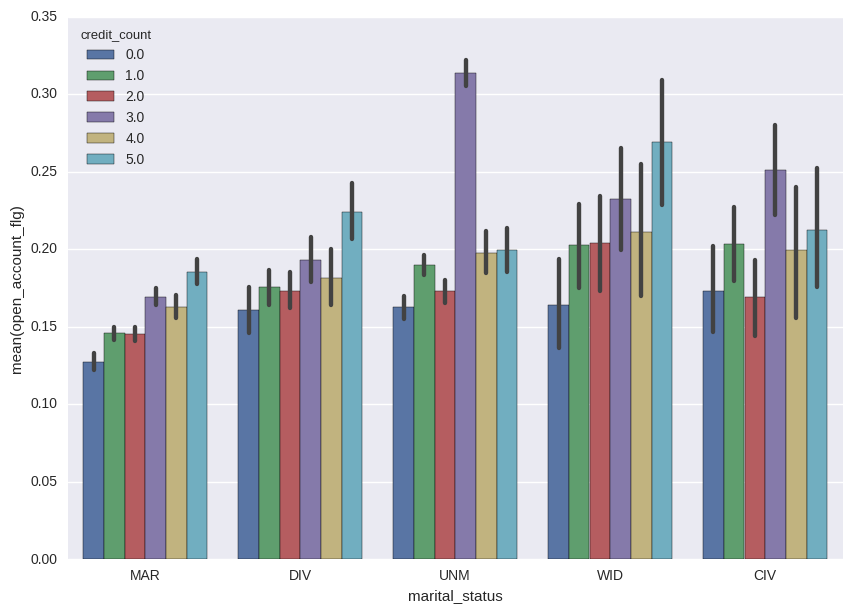

In [40]:
sns.barplot(x=data.marital_status, y=data.open_account_flg, hue=data.credit_count)

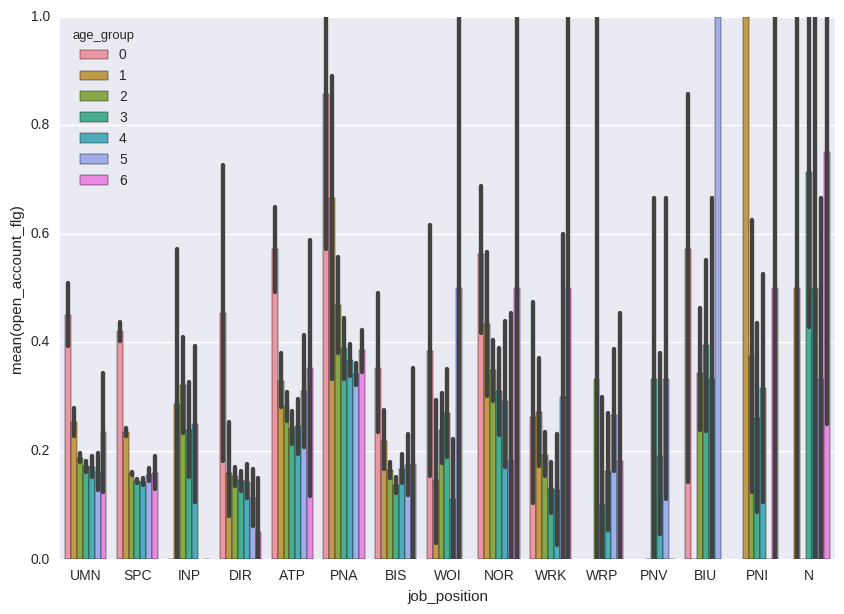

In [19]:
sns.barplot(x=data.job_position, y=data.open_account_flg, hue=data.age_group)

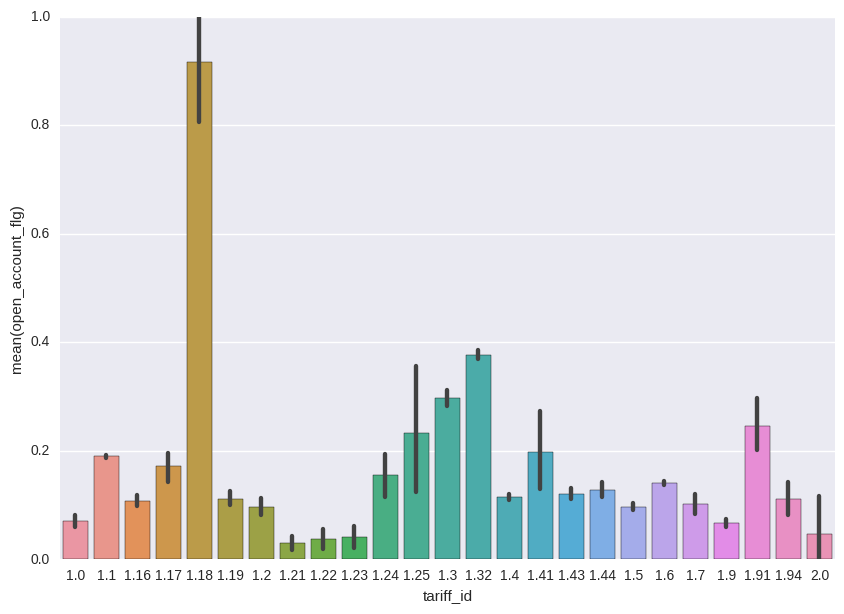

In [13]:
sns.barplot(x=data.tariff_id, y=data.open_account_flg)

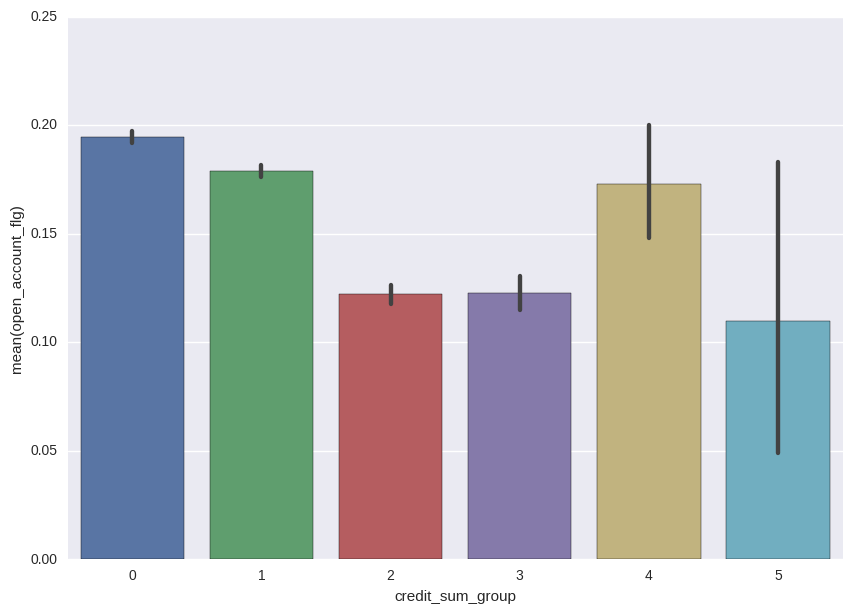

In [7]:
sns.barplot(x=data.credit_sum_group, y=data.open_account_flg)

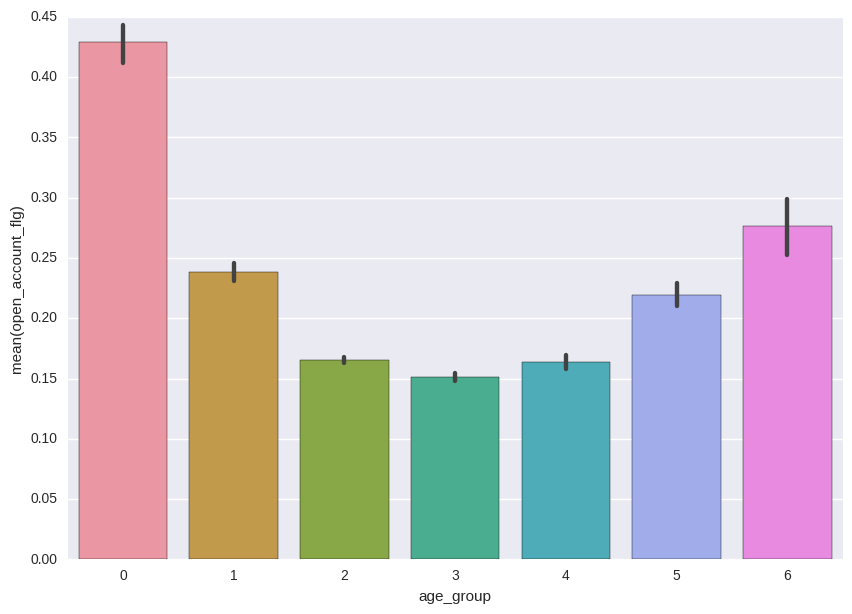

In [8]:
sns.barplot(x=data.age_group, y=data.open_account_flg)

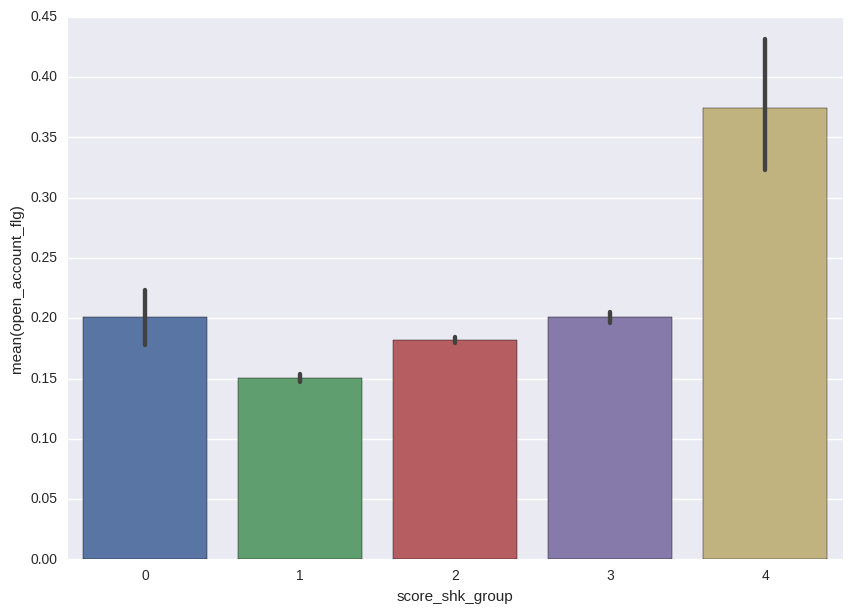

In [7]:
sns.barplot(x=data.score_shk_group, y=data.open_account_flg)

In [8]:
#счетчики
X_train = np.hstack((make_counters(X=data[counters_cols + pair_cols].values, y=data.open_account_flg.values, 
                                   n_folds=20), data[other_cols]))
X_test = np.hstack((make_counters_test(data_test[counters_cols + pair_cols].values, data[counters_cols + pair_cols].values, 
                                       data.open_account_flg.values), data_test[other_cols]))

In [9]:
dtrain = pd.DataFrame(data=X_train, columns=counters_cols + pair_cols + other_cols)
dtest = pd.DataFrame(data=X_test, columns=counters_cols + pair_cols + other_cols)

In [52]:
pickle_save(dtrain, 'data/task1_data/dtrain.pkl')
pickle_save(dtest, 'data/task1_data/dtest.pkl')
pickle_save(data_test.client_id.values, 'data/task1_data/_ID_.pkl')
pickle_save(data.open_account_flg.values, 'data/task1_data/y_train.pkl')
pickle_save(counters_cols + pair_cols + other_cols, 'task1_outputs/feature_names.pkl')

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
cols = ['gender', 'marital_status', 'job_position', 'credit_month', 'tariff_id', 
        'education', 'living_region', 'age', 'credit_count', 'overdue_credit_count',
        'credit_sum', 'score_shk', 'monthly_income', 'monthly_credit_sum']

In [36]:
dtrain = pickle_load('data/task1_data/dtrain.pkl')
dtest = pickle_load('data/task1_data/dtest.pkl')
y_train = pickle_load('data/task1_data/y_train.pkl')
dtrain['feat1'] = 0
dtest['feat1'] = 0

In [38]:
kf = StratifiedKFold(y_train, 5, True, random_state=27)
clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
for train_ind, test_ind in kf:
    clf.fit(dtrain[cols].loc[train_ind], y_train[train_ind])
    dtrain.loc[test_ind, 'feat1'] = clf.predict_proba(dtrain[cols].loc[test_ind])[:, 1]
clf.fit(dtrain[cols], y_train)
dtest['feat1'] = clf.predict_proba(dtest[cols])[:, 1]

In [45]:
dtrain.feat1.values[:20]

array([ 0.18,  0.46,  0.3 ,  0.19,  0.04,  0.03,  0.17,  0.09,  0.4 ,
        0.13,  0.08,  0.29,  0.17,  0.07,  0.05,  0.02,  0.09,  0.16,
        0.1 ,  0.15])

In [46]:
dtrain.tariff_id.values[:20]

array([ 0.14089356,  0.19031646,  0.19031646,  0.19066367,  0.18988322,
        0.19036353,  0.09865659,  0.1893844 ,  0.14106989,  0.19023776,
        0.07015903,  0.37740823,  0.14102426,  0.19016741,  0.09716372,
        0.19015772,  0.11391797,  0.18988322,  0.14092768,  0.14117457])

In [47]:
from sklearn.metrics import roc_auc_score

In [49]:
roc_auc_score(y_train, dtrain.feat1.values)

0.74430437268632654

In [51]:
dtest.head()

,gender,marital_status,job_position,credit_month,tariff_id,education,living_region,age,credit_count,overdue_credit_count,...,job_position__monthly_income_group,job_position__score_shk_group,credit_sum_group__monthly_income_group,credit_sum_group__score_shk_group,monthly_income_group__score_shk_group,credit_sum,score_shk,monthly_income,monthly_credit_sum,feat1
0,0.159821,0.152930,0.189013,0.140025,0.190190,0.139553,0.199170,0.152529,0.157622,0.162862,...,0.197256,0.179499,0.194356,0.168900,0.151900,16558.00,0.370409,34000.0,1655.800000,0.04
1,0.193563,0.152930,0.166347,0.230965,0.114291,0.205127,0.205048,0.168127,0.169440,0.162862,...,0.166213,0.138487,0.200767,0.168900,0.160105,7028.72,0.377281,19000.0,1171.453333,0.19
2,0.159821,0.211252,0.166347,0.140025,0.141006,0.205127,0.176862,0.463713,0.165412,0.162862,...,0.170035,0.172708,0.194356,0.201487,0.186846,13019.00,0.538515,25000.0,1301.900000,0.18
3,0.159821,0.152930,0.166347,0.140025,0.190190,0.139553,0.216416,0.148092,0.144916,0.162862,...,0.170035,0.172708,0.194356,0.201487,0.186846,9379.00,0.482520,30000.0,937.900000,0.28
4,0.159821,0.152930,0.166347,0.230965,0.120804,0.139553,0.192604,0.166470,0.157622,0.162862,...,0.166213,0.172708,0.200767,0.201487,0.196839,13990.00,0.485914,20000.0,2331.666667,0.10


In [44]:
y_train[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [11]:
from sklearn.cross_validation import train_test_split

In [12]:
?train_test_split

In [9]:
X_test.shape, X_train.shape

((91940, 59), (170746, 59))